In [3]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.1 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 1.9 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
np.random.seed(42)
df = pd.DataFrame({
    "x": np.random.normal(50, 40, 100),
    "y": np.random.normal(100, 20, 100)
})

In [21]:
def detect_outliers_iqr(series: pd.Series) -> pd.Series:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (series < lower_bound) | (series > upper_bound)

In [22]:
def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    z_scores = np.abs(stats.zscore(series, nan_policy='omit'))
    return z_scores > threshold

In [23]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return series.clip(lower=lower_bound, upper=upper_bound)

In [24]:
df["outlier_iqr"] = detect_outliers_iqr(df["y"])
df["outlier_zscore"] = detect_outliers_zscore(df["y"])


In [25]:
print(df["outlier_iqr"].sum(), "outliers by IQR")
print(df["outlier_zscore"].sum(), "outliers by Z-score")

1 outliers by IQR
0 outliers by Z-score


In [26]:
summary = pd.DataFrame({
    "with_outliers": [df["y"].mean(), df["y"].median(), df["y"].std()],
    "without_outliers": [
        df.loc[~df["outlier_iqr"], "y"].mean(),
        df.loc[~df["outlier_iqr"], "y"].median(),
        df.loc[~df["outlier_iqr"], "y"].std()
    ],
    "winsorized": [
        winsorize_series(df["y"]).mean(),
        winsorize_series(df["y"]).median(),
        winsorize_series(df["y"]).std()
    ]
}, index=["mean", "median", "std"])

summary


,with_outliers,without_outliers,winsorized
mean,100.446092,99.901069,100.280418
median,101.682143,101.371259,101.682143
std,19.073379,18.371114,17.859192


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

def fit_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    preds = model.predict(X)
    return {
        "coef": model.coef_[0],
        "intercept": model.intercept_,
        "R2": r2_score(y, preds),
        "MAE": mean_absolute_error(y, preds)
    }

results = {
    "with_outliers": fit_regression(df[["x"]], df["y"]),
    "without_outliers": fit_regression(df.loc[~df["outlier_iqr"], ["x"]], df.loc[~df["outlier_iqr"], "y"]),
    "winsorized": fit_regression(df[["x"]], winsorize_series(df["y"]))
}

pd.DataFrame(results)


,with_outliers,without_outliers,winsorized
coef,-0.071629,-0.042040,-0.057137
intercept,103.729986,101.860422,102.899907
R2,0.018611,0.006674,0.013507
MAE,14.991588,14.681536,14.437063


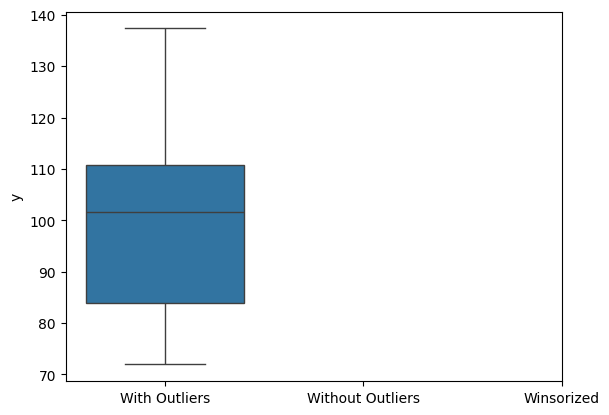

In [28]:
sns.boxplot(data=[df["y"], df.loc[~df["outlier_iqr"], "y"], winsorize_series(df["y"])])
plt.xticks([0,1,2], ["With Outliers", "Without Outliers", "Winsorized"])
plt.ylabel("y")
plt.show()


Outliers inflated the mean and standard deviation, while the median remained stable, confirming its robustness .Winsorizing gave results closer to the trimmed dataset but preserved more observations.

Assumptions & Risks:

I assumed that extreme points were noise, not meaningful rare events.

If those outliers actually represent valid rare phenomena, removing them risks losing important signals.

Winsorizing assumes that capping extremes preserves relationships, which may not hold in nonlinear contexts.

Overall, results show that conclusions can change substantially depending on how outliers are handled, highlighting the importance of documenting and justifying choices.